# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [19]:
from sklearn.datasets import load_boston
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the Boston Housing dataset
boston = load_boston()

# Convert the dataset to a DataFrame
X = boston.data

# Add the target variable (median value of the houses) to the DataFrame
y = boston.target

In [20]:

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        self.samples = X
        self.targets = y
        self.n_trees = n_trees 
        self.sample_sz =  sample_sz
        if isinstance(n_features,float): ## converts percentage to number of features
            self.n_features =  int(n_features *  X.shape[1])
        else:
            self.n_features = n_features
        self.min_leaf = min_leaf
        self.trees = [] # List holding all the trees.
        self.oob_scores = np.zeros(shape=(2,X.shape[0])) # List holding OOB score for each tree, used to calculate oob_mse.
        self.cols = []
        self.create_trees()
        


    def create_trees(self):
        
        for i in range(self.n_trees): # loop creating n_trees
            
            # partition data by rows and features (in bag data)
            ib_X,ib_y,oob_X,oob_y,indx = self.bootstrap(i) # ib = in_bag

            # generate tree
            tree = DecisionTreeRegressor(random_state = i ,min_samples_leaf=self.min_leaf,max_features = self.n_features) 
            tree.fit(ib_X, ib_y) 
            self.trees.append(tree)
            
            # calculate oob_error and append oob_scores list
            self.oob_scores[0,indx] += tree.predict(oob_X)
            self.oob_scores[1,indx] += 1


        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.oob_scores = self.oob_scores[0,:] / self.oob_scores[1,:]

        
    def bootstrap(self,i):
        np.random.seed(i)
        rows = np.random.choice(self.samples.shape[0], self.sample_sz, replace=False)
        oob_idx = np.setdiff1d(np.arange(self.samples.shape[0]), rows)
        cols = np.random.choice(self.samples.shape[1], self.n_features, replace=False)
        ib_y = self.targets[rows]
        ib_X = self.samples[rows, :][:, cols]
        oob_X = self.samples[oob_idx, :][:, cols]
        oob_y = self.targets[oob_idx]
        self.cols.append(cols)
        return ib_X, ib_y, oob_X, oob_y,oob_idx

 
    def oob_mse(self):
        return np.mean((self.oob_scores - self.targets)**2)

    def predict(self, X):    
        y_pred = []
        for row in X:
            pred = []
            for i in range(self.n_trees):
                relev_row = row[self.cols[i]]
                pred.append( self.trees[i].predict(relev_row.reshape(1,-1)))
            y_pred.append(np.mean(pred))
        return y_pred

In [21]:
best_mse = np.inf
best_hyper = []

for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for n_features in [3,5,10]:
      for min_leaf in [1,5]:
        forest = TreeEnsemble(X, y, n, sz, n_features,min_leaf)
        mse = forest.oob_mse()        
        if best_mse > mse:
          best_mse = mse
          best_hyper = [n,sz,n_features,min_leaf]

print(best_hyper)
print(best_mse)

[100, 300, 10, 1]
11.594235875801639


1.832621743083004


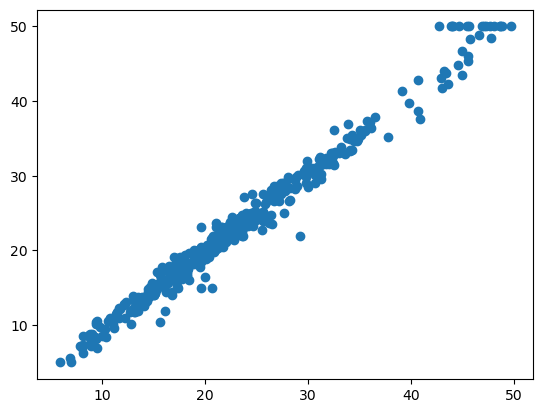

In [22]:
forest = TreeEnsemble(X,y,*best_hyper)
y_hat = forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y)
print(np.mean((y_hat - y)**2))

## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





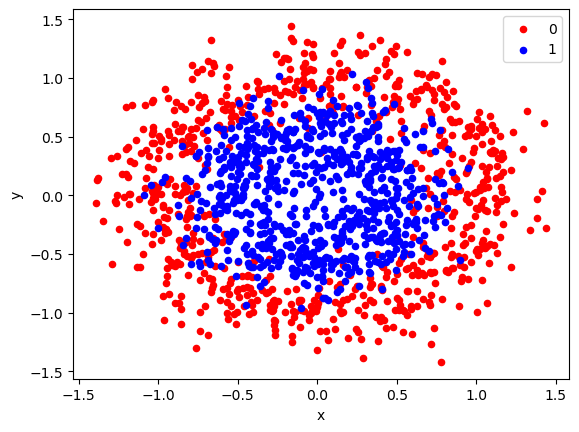

In [23]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.tree_.impurity[0]


0.5

In [31]:
class AdaBoost:
    def __init__(self, base_estimator, n_estimators=50, estimator_params=[]):
        self.estimator_params = estimator_params
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []

    
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        self.sample_weights = np.ones(n_samples) / n_samples
        
        for i in range(self.n_estimators):
            estimator = self.base_estimator(**self.estimator_params)
            estimator.fit(X, y, sample_weight=self.sample_weights)
            
            y_pred = estimator.predict(X)
            # accuracy = (y_pred == y).mean()
            # err = self.sample_weights[(y_pred != y)].sum()
            err = ((y != y_pred) * self.sample_weights).sum()
            
            estimator_weight = np.log((1 - err) / err) / 2
            
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight)
            
            self.sample_weights *= np.exp(-estimator_weight * y * y_pred)
            self.sample_weights /= self.sample_weights.sum()
        return self.sample_weights
            
    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        
        for estimator, estimator_weight in zip(self.estimators, self.estimator_weights):
            predictions += estimator_weight * estimator.predict(X)
        
        return np.sign(predictions)

In [32]:
# Split the sample set into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train==0,-1,1) # our classifier needs 1 and -1 values
y_test = np.where(y_test==0,-1,1) # our classifier needs 1 and -1 values

In [51]:
import matplotlib
colors = ['red','blue']

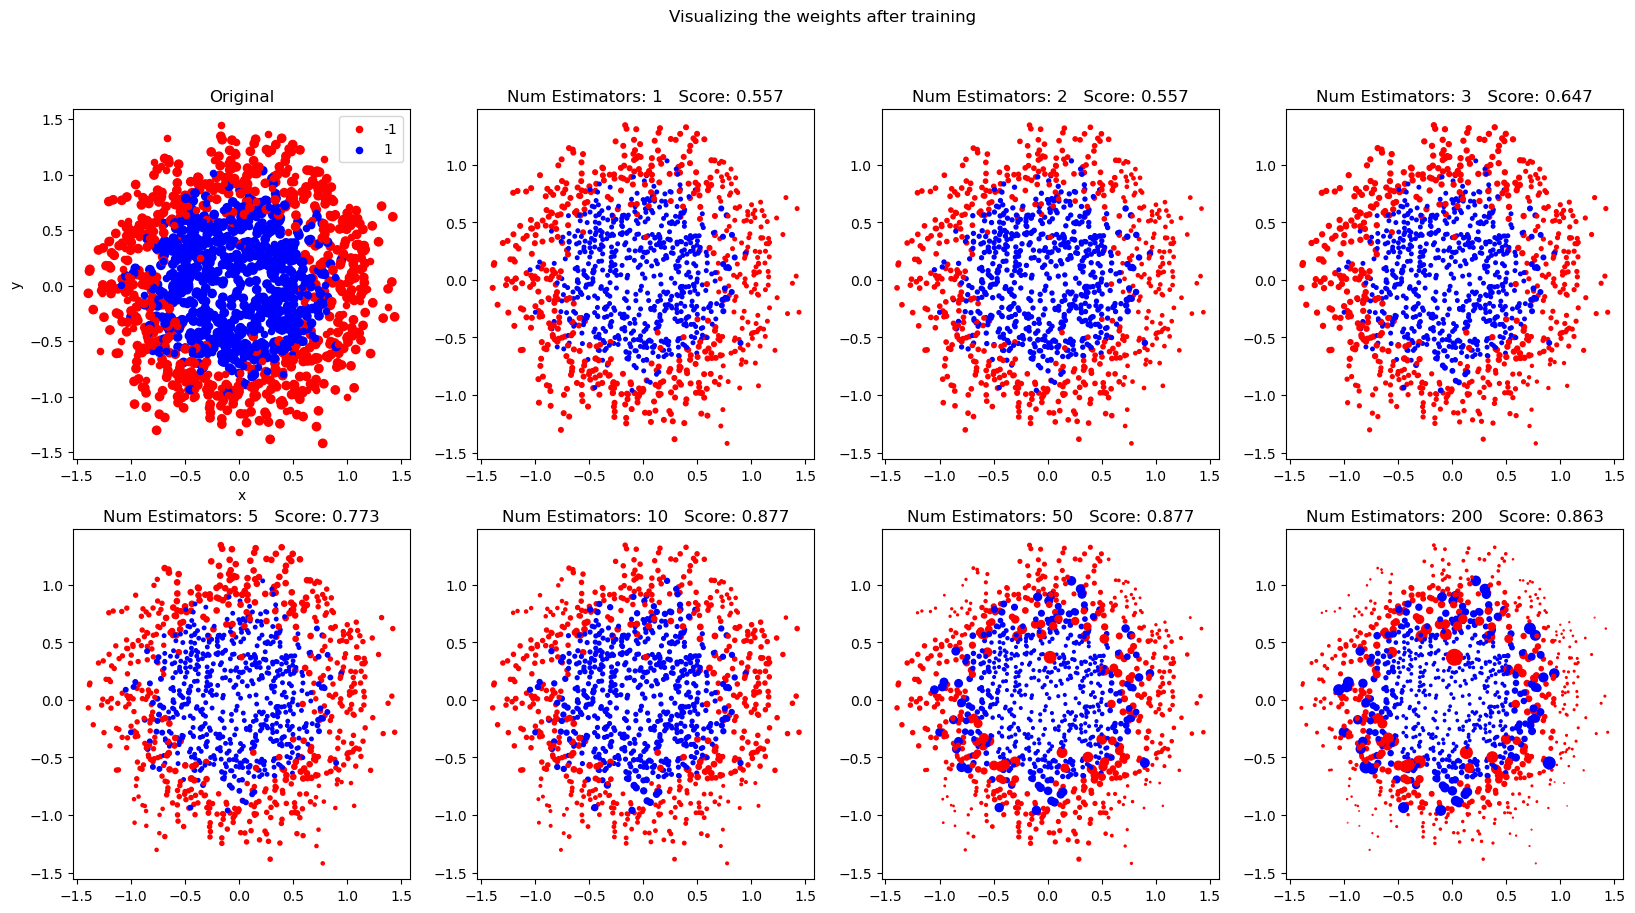

In [72]:
# scatter plot, dots colored by class value
learners = []
n_learners = [1, 2, 3, 5, 10, 50, 200]
weights = []
scores = []
for j in n_learners:

    dt = DecisionTreeClassifier
    estimator_params = {'max_depth':1}
    ada = AdaBoost(base_estimator=dt, n_estimators=j, estimator_params=estimator_params)
    weights.append(ada.fit(X_train, y_train))
    y_pred = ada.predict(X_test)
    scores.append(np.array((y_test == y_pred)).mean())
    learners.append(y_pred)



fig, axes = plt.subplots(2,4, figsize=(20, 10))
ax = axes.ravel()

ax[0].scatter(x=X_train[:,0], y=X_train[:,1], label=y_train, c=y_train,cmap = matplotlib.colors.ListedColormap(['red', 'blue']))
title = 'Original'
ax[0].set_title(title)

for key, group in grouped:
    group.plot(ax=ax[0], kind='scatter', x='x', y='y', label=key, color=colors[key], title='Original')

for i in range(len(learners)):
    ax[i+1].scatter(x=X_train[:,0], y=X_train[:,1], label=learners[i], s=weights[i]*10000, c=y_train,cmap = matplotlib.colors.ListedColormap(['red', 'blue']))
    title = 'Num Estimators: '+str(n_learners[i]) + '   Score: ' + str(round(scores[i],  3))
    ax[i+1].set_title(title)
    

plt.suptitle('Visualizing the weights after training')
pyplot.show()
   


In [73]:
scores

[0.5566666666666666,
 0.5566666666666666,
 0.6466666666666666,
 0.7733333333333333,
 0.8766666666666667,
 0.8766666666666667,
 0.8633333333333333]

As the the number of trees increase we see an increase in scores up until 50 trees, in 200 we see a decrease that might indicate we are starting to overfit.

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [82]:
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [89]:
class L2Boost():
    def __init__(self, n_estimators, regularizer, early_stop=True):
        self.n_estimators = n_estimators
        self.regularizer = regularizer
        self.residuals = []
        self.trees = []
        self.early_stop = early_stop

    def fit(self, X, y):
        # Initializing result vector with mean of y
        y_pred = np.mean(y) * np.ones(shape=y.shape)
        self.residuals.append(y_pred)

        
        for i in range(self.n_estimators):
            r_i = y - y_pred
            dtr = DecisionTreeRegressor(max_depth=1)

            dtr.fit(X, r_i)
            # Calculating residual of tree num i
            self.trees.append(dtr)
            y_pred = y_pred +  self.regularizer * dtr.predict(X)
            

    def predict(self, X):
        y_pred = self.residuals[0][0] * np.ones(shape=(X.shape[0]))
        for tree in self.trees:
            y_pred = y_pred + self.regularizer * tree.predict(X)
        return y_pred






In [117]:
max_depths = [2, 5, 10, 15, 75, 100,200]
scores = []
for depth in max_depths:
    dtr = DecisionTreeRegressor(max_depth=depth)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)

print(scores)

[25.9931908959712, 20.356259525823308, 11.323548150617418, 10.515954951425016, 22.905392156862746, 11.637647058823532, 11.190294117647062]


The best depth can fluctuate, depending on the random state.<br>
Usually depth 10 gives the best score.

In [115]:
n_trees = [1, 2, 5, 10, 15, 75, 100,200,400,1000,2000]
scores = []

for n in n_trees:
    l2boost = L2Boost(n,0.1)
    l2boost.fit(X_train, y_train)
    y_pred = l2boost.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)

print(scores)

[69.9343631503984, 63.73386096213381, 51.85074866860265, 39.06253665013027, 30.253576121273454, 15.234733231066379, 14.52681979717445, 13.399175828035876, 12.801531656782128, 12.559869562422277, 12.001109824524205]


The highest number of iterations seems to give the best score

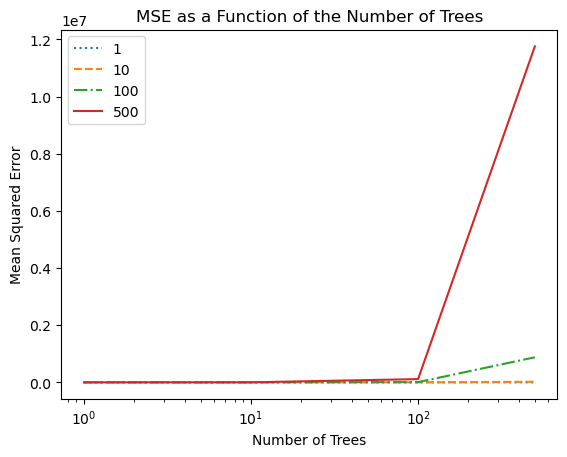

In [118]:
model = L2Boost(n_estimators=100,regularizer=0.1)

# Generate a logspace of n_trees up to 1000
n_trees = np.logspace(0, 3, num=10, dtype=int)

# Store the MSE for each number of trees
line_styles = ['dotted', 'dashed','dashdot', 'solid']

n_iters = [1,10,100,500]
for n in range(len(n_iters)):
    mse = []
    for reg in [0.001, 0.01, 0.1, 1]:
        model.n_estimators = n_iters[n]
        model.regularizer = reg
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse.append(((y_test - y_pred)**2).mean())
    plt.plot(n_iters, mse, linestyle=line_styles[n])
plt.legend(n_iters)
# Plot the MSE as a function of the number of trees

plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('MSE as a Function of the Number of Trees')
plt.show()